In [1]:
%%capture
!pip install transformers
!pip install evaluate


In [67]:

import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
import json

In [73]:

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
sns.set_theme()

In [4]:
# set the seed: built-in python, numpy, and pytorch
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [6]:
from transformers import AutoTokenizer, AutoModel,AutoModelForSequenceClassification

In [36]:
# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model=AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=2)#,ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropo

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBert

In [8]:

text = []
with open('/content/climate-fever-dataset-r1.jsonl') as f:
    for jsonObj in f:
        t = json.loads(jsonObj)
        text.append(t)

In [9]:
df=pd.DataFrame(columns=['claim','label'])
for i in text:
  row={'claim':i['claim'],'label':i['claim_label']}
  df=df.append(row,ignore_index=True)

df['label']=df['label'].apply(lambda x: 1 if x=='SUPPORTS' else 0)

In [ ]:
df['label'].value_counts()

0    881
1    654
Name: label, dtype: int64

In [ ]:
df.shape

(1535, 2)

In [18]:
# labeled_samples['label'].value_counts()

0    139
1     95
Name: label, dtype: int64

In [15]:
all_data=df

In [19]:
x_train,x_test,y_train,y_test=train_test_split(all_data['claim'].to_list(),all_data['label'].to_list(),random_state=13,stratify=all_data['label'].to_list())

In [ ]:
#baseline

In [37]:
x_train_tok=tokenizer(x_train, truncation=True,max_length=330,padding=True,return_tensors='pt')#can use the max len+10/20 from the corpus (power of 2)
x_test_tok=tokenizer(x_test, truncation=True,max_length=330,padding=True,return_tensors='pt')

In [21]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = Dataset(x_train_tok, y_train)
#val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = Dataset(x_test_tok, y_test)

In [22]:
from transformers import TrainingArguments
import evaluate
from transformers import TrainingArguments, Trainer

In [23]:
metric=evaluate.load("accuracy")

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [38]:
training_args = TrainingArguments( 
    learning_rate=5e-5,
    num_train_epochs=4,
    #evaluation_strategy="epoch",
    per_device_train_batch_size=8,#8
    per_device_eval_batch_size=8,
    logging_steps=200,
    output_dir="outputs",
    overwrite_output_dir=True,
    evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [40]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1151
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 576
  Number of trainable parameters = 66955010
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.668805,0.627604
2,0.643800,0.709054,0.645833
3,0.398600,1.058377,0.585938
4,0.398600,1.357425,0.627604


***** Running Evaluation *****
  Num examples = 384
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 384
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/loca

TrainOutput(global_step=576, training_loss=0.40985336899757385, metrics={'train_runtime': 51.5012, 'train_samples_per_second': 89.396, 'train_steps_per_second': 11.184, 'total_flos': 97676078280864.0, 'train_loss': 0.40985336899757385, 'epoch': 4.0})

In [41]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 384
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: token_type_ids. If token_type_ids are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.


{'eval_loss': 1.3574246168136597,
 'eval_accuracy': 0.6276041666666666,
 'eval_runtime': 0.9689,
 'eval_samples_per_second': 396.339,
 'eval_steps_per_second': 49.542,
 'epoch': 4.0}

In [77]:
unlabeled_index=random.sample(range(0,1151),1051)
labeled_index=list(set(range(1151))-set(unlabeled_index))


In [78]:
unlabeled_samples=pd.DataFrame(columns=['claim','label'])
unlabeled_samples['claim']=[x_train[i] for i in unlabeled_index]
unlabeled_samples['label']=[y_train[i] for i in unlabeled_index]

In [79]:
labeled_samples=pd.DataFrame(columns=['claim','label'])
labeled_samples['claim']=[x_train[i] for i in labeled_index]
labeled_samples['label']=[y_train[i] for i in labeled_index]

Use modAL

In [11]:
%%capture
!pip install modAL
!pip install skorch

In [35]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from skorch import NeuralNetClassifier, NeuralNet
from sklearn.pipeline import Pipeline
from skorch.callbacks import LRScheduler, ProgressBar
from skorch.hf import HuggingfacePretrainedTokenizer

In [42]:
# Choose a tokenizer and BERT model that work together
TOKENIZER = "distilbert-base-uncased"# "nbroad/ESG-BERT"
PRETRAINED_MODEL = "distilbert-base-uncased"#"nbroad/ESG-BERT"
OPTMIZER = torch.optim.AdamW
LR = 5e-5
MAX_EPOCHS = 4
CRITERION = torch.nn.CrossEntropyLoss
BATCH_SIZE = 8
DEVICE='cuda'

In [43]:
tokenizer=HuggingfacePretrainedTokenizer(TOKENIZER)

In [107]:
X_initial=labeled_samples['claim'].to_numpy()
#tokenizer.fit(X_initial,max_length=330)
#X_initial=tokenizer.transform(X_initial)

y_initial=labeled_samples['label'].to_numpy()

In [108]:
X_pool=unlabeled_samples['claim'].to_numpy()
y_pool=unlabeled_samples['label'].to_numpy()

In [82]:
labeled_samples['label'].value_counts()

0    60
1    40
Name: label, dtype: int64

In [49]:
X_test=x_test

In [46]:
class BertModule(torch.nn.Module):
    def __init__(self, name, num_labels):
        super().__init__()
        self.name = name
        self.num_labels = num_labels
        
        self.reset_weights()
        
    def reset_weights(self):
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            self.name, num_labels=self.num_labels#,ignore_mismatched_sizes=True
        )
        
    def forward(self, **kwargs):
        pred = self.bert(**kwargs)
        return pred.logits

In [47]:
# classifier = NeuralNetClassifier(BertModule,
#                                 module__name=PRETRAINED_MODEL,
#                                  module__num_labels=2,
#                                  criterion=torch.nn.CrossEntropyLoss,
#                                  optimizer=torch.optim.AdamW,
#                                  train_split=None,
#                                  verbose=1,
#                                  device=DEVICE)

In [100]:
pipeline = Pipeline([
    ('tokenizer', HuggingfacePretrainedTokenizer(TOKENIZER)),
    ('net', NeuralNetClassifier(
        BertModule,
        module__name=PRETRAINED_MODEL,
        module__num_labels=2,
        optimizer=OPTMIZER,
        lr=LR,
        max_epochs=MAX_EPOCHS,
        criterion=CRITERION,
        batch_size=BATCH_SIZE,
        iterator_train__shuffle=True,
        device=DEVICE,
        #callbacks=[
            #LRScheduler(LambdaLR, lr_lambda=lr_schedule, step_every='batch'),
           # ProgressBar(),
        #],
    )),
])

In [ ]:
# pipeline.fit(X_initial,y_initial)

In [101]:
learner = ActiveLearner(
    estimator=pipeline,
    X_training=X_initial, y_training=y_initial
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7015       0.6000        0.6757  1.9875
      2        0.6729       0.6000        0.6722  1.9503
      3        0.6568       0.6000        0.6626  1.9536
      4        0.6031       0.6500        0.6059  1.9649


In [102]:
y_pred=learner.predict(X_test)

In [103]:
print(accuracy_score(np.array(y_test),np.array(y_pred)))

0.5911458333333334


In [109]:
performance_hist=[]
n_queries = 10
for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(X_pool,n_instances=80) #
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=True,
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

    y_pred=learner.predict(X_test)
    performance_hist.append(accuracy_score(np.array(y_test),np.array(y_pred)))

Query no. 1


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6892       0.6250        0.6766  1.5627
      2        0.6080       0.6250        0.7285  1.5811
      3        0.4780       0.6250        0.8957  1.5790
      4        0.2942       0.5625        1.0887  1.5800
Query no. 2


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7102       0.5625        0.6930  1.5763
      2        0.6302       0.5625        0.6963  1.5935
      3        0.5489       0.5000        0.7232  1.5871
      4        0.3743       0.5000        0.8389  1.5957
Query no. 3


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7019       0.6250        0.6697  1.5761
      2        0.6732       0.6250        0.6632  1.5825
      3        0.6124       0.6250        0.6833  1.5789
      4        0.4886       0.6250        0.6995  1.5819
Query no. 4


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7111       0.5625        0.6794  1.5627
      2        0.6594       0.5625        0.6888  1.5819
      3        0.5797       0.5625        0.7517  1.5860
      4        0.3370       0.5625        1.0632  1.5835
Query no. 5


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7058       0.6250        0.6833  1.5642
      2        0.6481       0.6250        0.6705  1.6209
      3        0.5686       0.5625        0.6926  1.5778
      4        0.3449       0.5625        0.8240  1.5801
Query no. 6


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7063       0.5625        0.6866  1.5720
      2        0.6613       0.5625        0.6785  1.5798
      3        0.5476       0.6875        0.5986  1.5973
      4        0.2960       0.6875        0.6467  1.5866
Query no. 7


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7091       0.6250        0.6730  1.5711
      2        0.6297       0.6250        0.6652  1.5836
      3        0.4664       0.5625        0.7136  1.5805
      4        0.2006       0.6250        0.7996  1.5773
Query no. 8


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6927       0.7500        0.6604  1.5651
      2        0.6071       0.8125        0.6209  1.5820
      3        0.4441       0.8125        0.5973  1.5810
      4        0.1833       0.5625        1.0154  1.5800
Query no. 9


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6954       0.6250        0.6702  1.5787
      2        0.6589       0.6250        0.6764  1.5872
      3        0.5979       0.6250        0.7620  1.5834
      4        0.4232       0.5625        0.8798  1.5873
Query no. 10


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapsh

Re-initializing module because the following parameters were re-set: name, num_labels.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7129       0.6250        0.6677  1.5752
      2        0.6359       0.6250        0.6957  1.5808
      3        0.4829       0.3750        0.8685  1.5822
      4        0.2250       0.6250        1.0163  1.5768


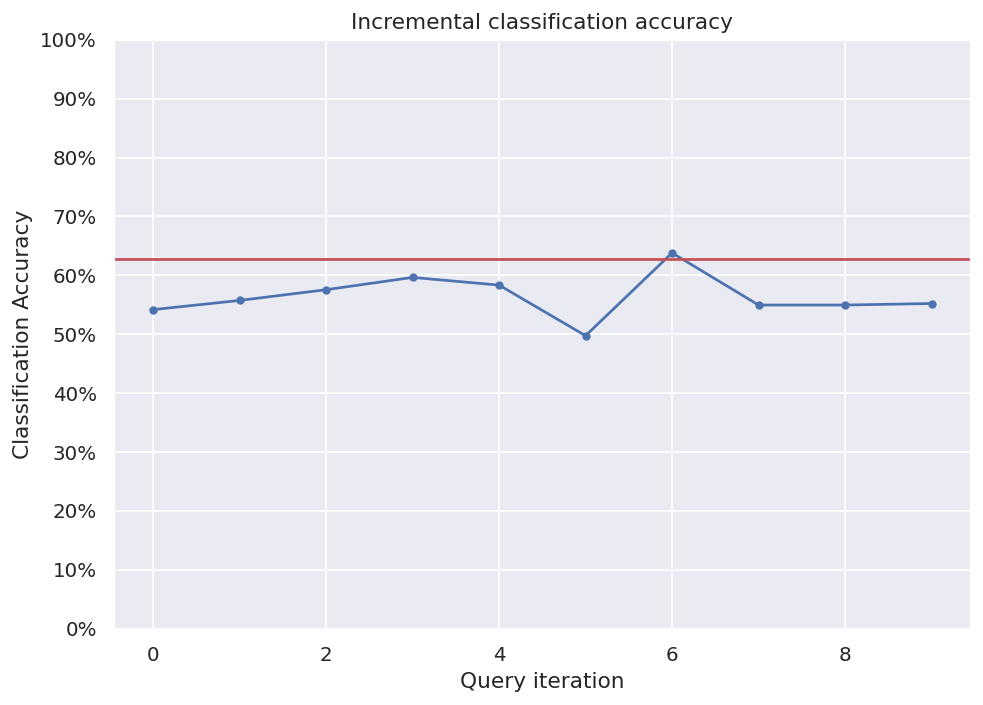

In [110]:
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_hist)
ax.scatter(range(len(performance_hist)), performance_hist, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.axhline(y = 0.6276041666666666, color = 'r', linestyle = '-')
ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()